## Demonstration of several algorithms on a toy dataset 

Pen Digits Dataset: https://www.dbs.ifi.lmu.de/research/outlier-evaluation/DAMI/literature/PenDigits/PenDigits_v01.html

Algorithms: KNN, LOF, Isolation Forest, Mahalonobis distance, PCA and Autoencoder reconstruction error
(extra: DBSCAN).


Using both scikit-learn and pyod packages

## Imports

In [425]:
# standard library imports
import os
import sys
from collections import Counter

# pandas, seaborn etc.
import seaborn as sns
import sklearn 
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np

# sklearn outlier models
from sklearn.neighbors import NearestNeighbors
# from sklearn.neighbors import LocalOutlierFactor # Use pyod's wrapper
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

# other sklearn functions
from sklearn.decomposition import PCA
from sklearn.covariance import MinCovDet, EmpiricalCovariance
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import scale as preproc_scale
from sklearn.manifold import TSNE

# pyod
import pyod
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.pca import PCA as pyod_PCA
from pyod.models.iforest import IForest


In [3]:
sys.path.append("..") #to enable importing from ../outlierutils
from outlierutils import plot_top_N, plot_outlier_scores

## Data loading

In [4]:
data_path = '../data/'
x_pen = pd.read_pickle(os.path.join(data_path, 'x_pendigits.pkl'))
y_pen = pd.read_pickle(os.path.join(data_path, 'y_pendigits.pkl'))

In [5]:
sc = StandardScaler()
x_pen = pd.DataFrame(data=sc.fit_transform(x_pen))

In [6]:
print('Number of points: {}'.format(len(y_pen)))
print('Number of positives: {} ({:.3%})'.format(y_pen.sum(), y_pen.mean()))

Number of points: 9868
Number of positives: 20 (0.203%)


## 0. Visualization with t-SNE

In [267]:
N_downsample = 3000
assert x_pen.index.equals(y_pen.index), 'Error, indexes differ. Reset them to continue'
x_downsampled = pd.concat((x_pen[y_pen==0].sample(N_downsample - int(y_pen.sum())),
                           x_pen[y_pen==1]), 
                          axis=0).sample(frac=1)
y_downsampled = y_pen[x_downsampled.index]

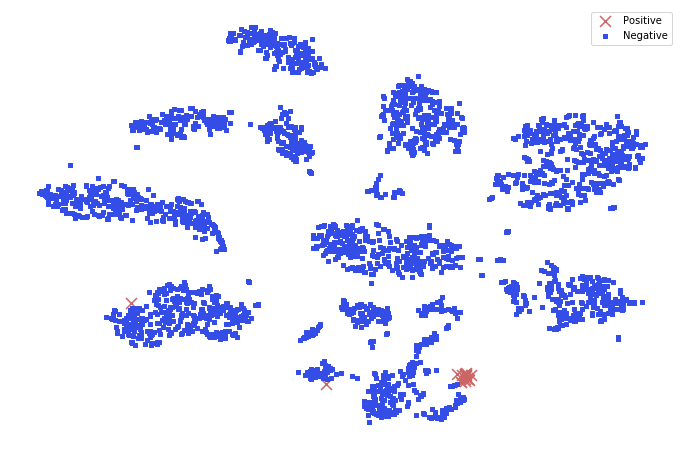

In [269]:
MAX_N_TSNE = 3500 #Avoid overly long computation times with TSNE. Values < 5000 recommended 
neg = y_downsampled == 0
pos = y_downsampled == 1

assert len(x_downsampled) <= MAX_N_TSNE, 'Using a dataset with more than {} points is not recommended'.format(
                                            MAX_N_TSNE)
X_2D = TSNE(n_components=2, 
            perplexity=50, 
            n_iter=400,
           random_state=5).fit_transform(x_downsampled) # collapse in 2-D space for plotting
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.scatter(X_2D[pos, 0], X_2D[pos, 1], c=[[0.8, 0.4, 0.4],], marker='x', s=120, label='Positive')
ax.scatter(X_2D[neg, 0], X_2D[neg, 1], c=[[0.2, 0.3, 0.9],], marker='s', s=10, label='Negative')

plt.axis('off')
plt.legend()
plt.show() 

#### A.0

Some observations:
- Depending on the perplexity, we see roughly 10 clusters, not all well-defined. This is in line with the expectation to see 9 + 1 (the 9 digits plus "4", the undersampled outlier class)
- The outlier class forms a single cluster, rather than being scattered across
- This corresponds to our understanding of the data: the outlier class is really an under-represented class

## 1a. Mahalonobis Distance, single cluster

We can calculate the Mahalonobis distance in two ways:
- Directly: Calculating the Covariance matrix (with the full data, or with the robust MinCovDet), then the Mahalonobis distance
- Indirectly: Do a whitened PCA decompose with full-rank, calculate the Euclidean distance

We will take the first option:

In [122]:
cov_ = EmpiricalCovariance().fit(x_pen)
#cov_ = MinCovDet().fit(x_pen) # Robust estimation
mahalonobis_pen = cov_.mahalanobis(x_pen)

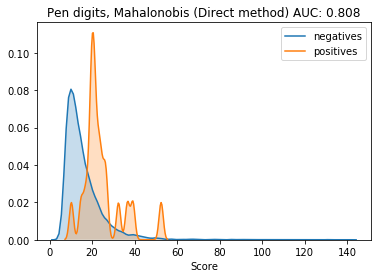

In [123]:
res = plot_outlier_scores(y_pen.values, mahalonobis_pen, bw=1, title='Pen digits, Mahalonobis')

## 1b. Mahalonobis Distance, GMM

In [230]:
gmm = GaussianMixture(n_components=9, covariance_type='full', random_state=1) # try also spherical
gmm.fit(x_pen, )
gmm_outlier_scores = - gmm.score_samples(x_pen)

In [231]:
gmm_outlier_scores = np.clip(gmm_outlier_scores, -15, 50)

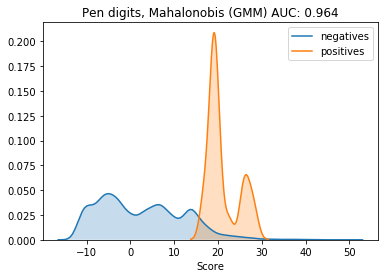

In [232]:
res = plot_outlier_scores(y_pen.values, gmm_outlier_scores, bw=1, title='Pen digits, Mahalonobis (GMM)')

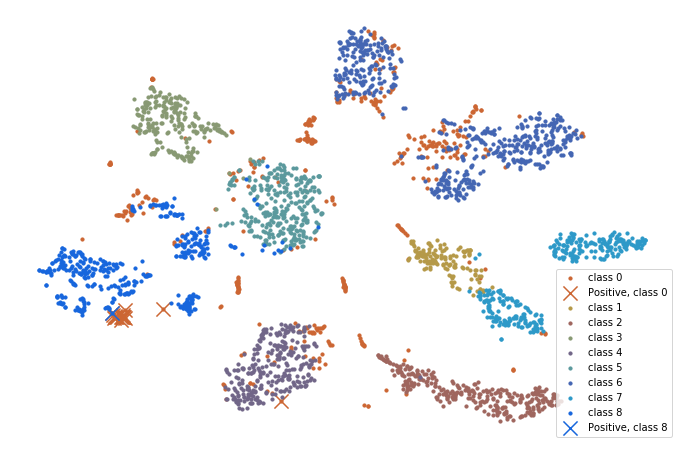

In [235]:
labels_ds = gmm.predict(x_downsampled)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

n_components = gmm.n_components
for i, class_ in enumerate(range(n_components)):
    idx = np.where(labels_ds == i)[0]
    idx_pos = np.where((labels_ds == i) & (pos.values))[0]
    
    c=[(0.8-0.8*(i/n_components), 0.4 + 0.2*(i%2), 0.2+0.75*(i/n_components)), ]
    ax.scatter(X_2D[idx, 0], X_2D[idx, 1], c=c, 
               marker='o', s=10, label=f'class {i}')
    if len(idx_pos):
        ax.scatter(X_2D[idx_pos, 0], X_2D[idx_pos, 1], c=c, 
           marker='x', s=200, label=f'Positive, class {i}')     

plt.axis('off')
plt.legend()
plt.show() 
    

Generally, most outliers are a minority fraction of the same cluster. GMM agrees quite well with t-SNE.

### 2. K-nearest neighbours

#### 2.1 Use the scikit-learn NearestNeighbors implementation to get neighbor statistics and outlier scores



#### A 2.1 
The probability of the nearest neighbour of a point being an outlier, conditional on the class membership of that point:

In [236]:
# First: verify that the nearest neighbours of outliers are usually outliers (as one may expect from the TSNE plot)
clf_nn = NearestNeighbors(n_neighbors=21) # NB: the first neighbour is the point itself
clf_nn.fit(x_pen)
Nth_neighbour = 1
nearest_ns = clf_nn.kneighbors(x_pen)[1][:, Nth_neighbour]

print('Fraction of {}st neighbor that is an outlier, conditional on y==1: {:.2%}'.format(Nth_neighbour, 
y_pen[nearest_ns[y_pen==1]].mean()))
      
print('Fraction of {}st neighbor that is an outlier, conditional on y==0: {:.2%}'.format(Nth_neighbour, 
y_pen[nearest_ns[y_pen==0]].mean()))

Fraction of 1st neighbor that is an outlier, conditional on y==1: 90.00%
Fraction of 1st neighbor that is an outlier, conditional on y==0: 0.00%


The first neighbour of an outlier is an outlier in 90% of the cases. Even the 10th neigbour is an outlier in more than 50 %. Indeed, as observed in t-SNE, outliers are close together in this case. 


**Extra: sci-kit learn implementation of KNN**

In [240]:
def get_median_distance(X, n_points=1, skip_first_distance=True):
    """
    X (np.array): distance array, shape Nxn_neighbors
    n_points (int): number of points to calculate the median distance from
    skip_first_distance (boolean or int): if True (or 1), the first column is ignored
    """
    dist_array=np.zeros(len(X))
    for i in range(len(X)):
        dist_array[i] = np.median(X[i][int(skip_first_distance):int(skip_first_distance) + n_points])
    return dist_array
        
def get_outlier_score(x_data, n_neighbors):
    """ Returns a 1-D numpy array with outlier scores
    """
    clf_nb = NearestNeighbors(n_neighbors=n_neighbors)
    clf_nb.fit(x_pen)
    neighbor_distances = clf_nb.kneighbors()[0] #1st array contains distances, 2nd contains points
    median_knn_pen = get_median_distance(neighbor_distances, n_points=n_neighbors)
    return median_knn_pen
    

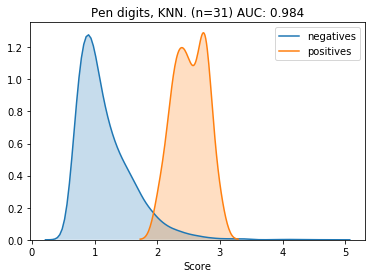

In [243]:
# Try n_neigbours 31 (NB: there are 20 outliers, that are close-by, so choose n > 2* 20)
n_neighbours = 31
knn_outlier_score = get_outlier_score(x_pen, n_neighbours)
res = plot_outlier_scores(y_pen.values, knn_outlier_score, bw=0.1, 
                          title='Pen digits, KNN. (n={})'.format(n_neighbours))

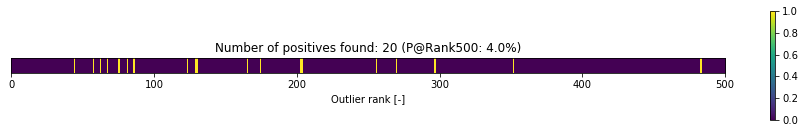

In [244]:
res = plot_top_N(y_pen.values, knn_outlier_score, N=500)

#### 2.2 Use pyod to get outlier scores

In [266]:
# train kNN detector
n_neighbours = 31

clf = KNN(method='median', n_neighbors=n_neighbours)
clf.fit(x_pen)
# get the prediction label and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

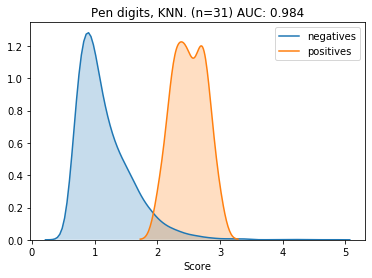

In [247]:
res = plot_outlier_scores(y_pen.values, clf.decision_scores_, bw=0.1, 
                          title='Pen digits, KNN. (n={})'.format(clf.n_neighbors))

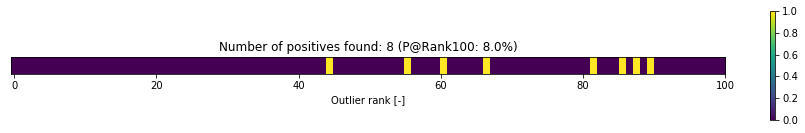

In [248]:
res = plot_top_N(y_pen.values, clf.decision_scores_)

**Extra: compare scores for a range of n_neighbors**

In [34]:
# Loop over a range of n_neighbours
n_neighbour_list = [1+i*5 for i in range(20)]
knn_scores = [KNN(method='median', n_neighbors=n).fit(x_pen).decision_scores_
                  for n in n_neighbour_list]

In [37]:
knn_roc_auc_scores = [roc_auc_score(y_pen, knn_score) for knn_score in knn_scores]
N_ = 100
knn_precision_at_N = [y_pen[np.argsort(knn_score)][::-1][:N_].mean() for knn_score in knn_scores]


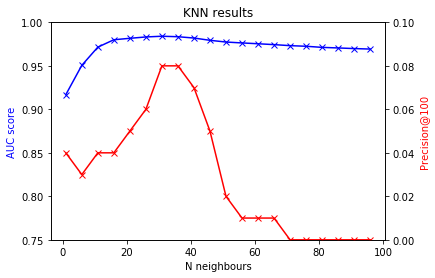

In [250]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

ax.plot(n_neighbour_list, knn_roc_auc_scores, 'b-x', label='ROC AUC [-]')
ax2.plot(n_neighbour_list, knn_precision_at_N, 'r-x', label=f'Precision@{N_}')
ax.set_xlabel('N neighbours');
ax.set_ylim([0.75, 1])
ax.set_ylabel('AUC score', color='b');
ax2.set_ylabel(f'Precision@{N_}', color='r');
ax2.set_ylim([0, 0.1])

ax.set_title('KNN results');

#### A. 2.2 

Precision@100 is much stronger affected by n_neighbours than the AUC score. 
The AUC score is a global metric, whereas we are (typically) more interested in the precision of the highest scores. 

Choosing n_neighbours too high leads to a dilution of the scores and a strong decrease in the top-N precision (when N is relatively small). 


### 3. LOF

#### A 3.1

LOF compares the "reachability-density" of an object to the average density of its neighbours. The reachability-density is an inverse of the reachability distance, which puts a lower limit on the distance between two points that is given on the distance of the kth-nearest neighbour. Points that are part of one cluster all have a similar density, and thus get a score of around 1. An isolated point has a much lower density than its nearest neighbour when that neighbour is part of a dense cluster, and gets a high outlier score. 

Since in the pendigits data outliers are clustered together, they may easily have comparable densities. Thus, when the value for K is too small (smaller than the cluster size), the algorithm will not detect differences in densities, and fail to recognize the outliers. 

LOF with k=10 will thus perform worse than KNN. 

https://en.wikipedia.org/wiki/Local_outlier_factor



#### A 3.2


**Example 1:** N_neighbours too low (N=10)

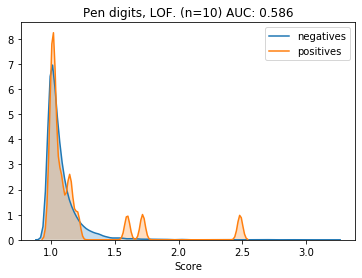

In [259]:
n_neighbours = 10
lof = LocalOutlierFactor(n_neighbors=n_neighbours, contamination=0.01)
lof.fit_predict(x_pen)
res = plot_outlier_scores(y_pen.values, -lof.negative_outlier_factor_, 
                          bw=0.02, title=f'Pen digits, LOF. (n={n_neighbours})')

**Example 2:** N_neighbours good (N=50)

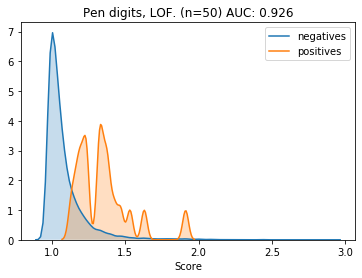

In [260]:
n_neighbours = 50
lof = LocalOutlierFactor(n_neighbors=n_neighbours, contamination=0.01)
lof.fit_predict(x_pen)
res = plot_outlier_scores(y_pen.values, -lof.negative_outlier_factor_, 
                          bw=0.02, title=f'Pen digits, LOF. (n={n_neighbours})')

**Extra: compare scores for a range of n_neighbors**

In [261]:
# Loop over a range of n_neighbours
n_neighbour_list = [1+i*5 for i in range(20)]
lof_scores = [LOF(n_neighbors=n).fit(x_pen).decision_scores_
                  for n in n_neighbour_list]

In [262]:
lof_roc_auc_scores = [roc_auc_score(y_pen, score) for score in lof_scores]
N_ = 100
lof_precision_at_N = [y_pen[np.argsort(score)][::-1][:N_].mean() for score in lof_scores]


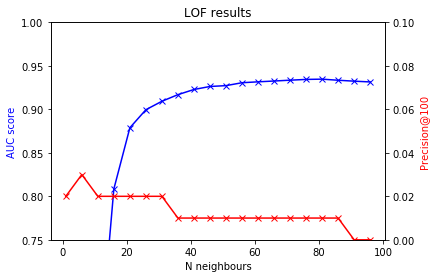

In [263]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

ax.plot(n_neighbour_list, lof_roc_auc_scores, 'b-x', label='ROC AUC [-]')
ax2.plot(n_neighbour_list, lof_precision_at_N, 'r-x', label=f'Precision@{N_}')
ax.set_xlabel('N neighbours');
ax.set_ylim([0.75, 1])
ax.set_ylabel('AUC score', color='b');
ax2.set_ylabel(f'Precision@{N_}', color='r');
ax2.set_ylim([0, 0.1])

ax.set_title('LOF results');

Note that LOF requires indeed a large n_neighbours to spot the outliers (for the AUC metric), whereas this dilutes the results, giving a worse precision@100. 

LOF is clearly less suited to this particular dataset. 


### 4. Isolation Forest

#### A 4.1

Isolation Forest makes splits in an orthogonal fashion. This means it is not rotationally invariant, and it will generate artefacts (points being easier to split in one of the axis directions).  

#### A 4.2
Running with n_estimators=1000, and 1024 samples will probably be close to optimal.

In [428]:
ifo = IForest(n_estimators=1000, max_samples=1024, random_state=1, contamination=0.01, behaviour='new')
ifo.fit(x_pen)
# NB: in contradiction to the documentation, there is no .decision_scores_ attribute for iForest
pen_isof_scores = ifo.decision_scores_ #ifo.decision_function(x_pen) 

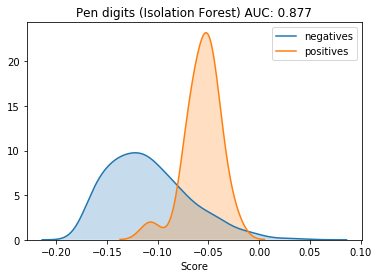

In [427]:
res = plot_outlier_scores(y_pen.values, pen_isof_scores, bw=0.01, title='Pen digits (Isolation Forest)')

#### A 4.3

**Optional: running several isoForest's and comparing scores**

Note the rather large variation of AUC ROC scores for `n_estimators`=100, by doing 10 calculations with different random seeds:

In [290]:
n_estimators=100
ifo_clfs = [IsolationForest(n_estimators=n_estimators, max_samples=512, random_state=i, contamination=0.01, behaviour='new')
            .fit(x_pen) for i in range(10)]
scores = [roc_auc_score(y_pen.values, -ifo_clf.decision_function(x_pen)) for ifo_clf in ifo_clfs]

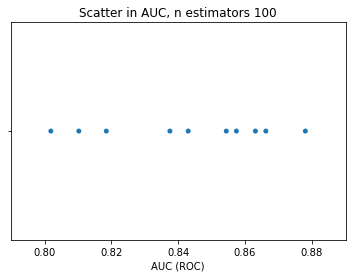

In [275]:
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('AUC (ROC)')
sns.swarmplot(scores, ax=ax);
ax.set_title(f'Scatter in AUC, n estimators {n_estimators}');
# with 100 trees: between 0.80 and 0.88
# with 1000 trees: between 0.83 and 0.86

### 5. PCA reconstruction error

#### A. 5.1

This is actually not an easy question at all. One may look at the explained variance ratio, but there is no golden rule for a cut-off here either. This is a parameter that can not be intuitively chosen (unlike the k in kNN). 


In [375]:
# NBA: the pyod PCA is implemented differently, and does not seem to work as intended 
# pca = pyod_PCA(n_components=5, weighted=False, n_selected_components=5, standardization=True).fit(x_pen)
# pca.fit(x_pen)
# pca_scores = pca.decision_scores_

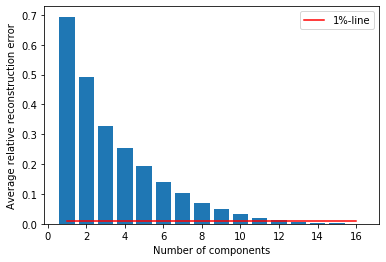

In [376]:
pca = PCA(n_components=16, whiten=False)
pca_tf = pca.fit_transform(x_pen_centered)
plt.bar(x=range(1, 17), height=1 - pca.explained_variance_ratio_.cumsum());
plt.ylabel('Average relative reconstruction error');
plt.legend()
plt.xlabel('Number of components');

In [389]:
pca = PCA(n_components=8, whiten=False)
pca_tf = pca.fit_transform(x_pen)
x_pen_recon = pca.inverse_transform(pca_tf)
pca_scores = ((x_pen - x_pen_recon)**2).mean(axis=1).values
#pca_scores = np.clip(pca_scores, 0, 200) # clip for plotting purposes

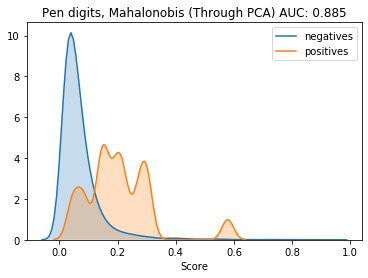

In [390]:
res = plot_outlier_scores(y_pen.values, pca_scores, bw=0.02, title='Pen digits, Mahalonobis (Through PCA)')

In [393]:
n_components_list = []
recon_error_list = []
auc_list = []
for i, n_components in enumerate(range(1, 15)):
    pca = PCA(n_components=n_components, whiten=False)
    pca_tf = pca.fit_transform(x_pen)
    x_pen_recon = pca.inverse_transform(pca_tf)
    pca_scores = ((x_pen - x_pen_recon)**2).mean(axis=1).values
    recon_error_list.append(1 - pca.explained_variance_ratio_[-1])
    n_components_list.append(n_components)
    auc_list.append(roc_auc_score(y_pen, pca_scores))
 

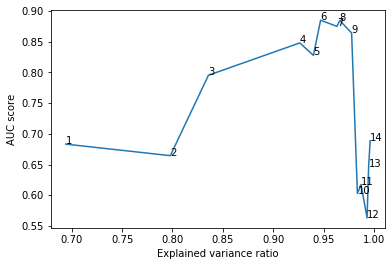

In [398]:
plt.plot(recon_error_list, auc_list)
for x, y, text in zip(recon_error_list, auc_list, n_components_list):
    plt.text(x, y, text)
plt.xlabel('Explained variance ratio')
plt.ylabel('AUC score');

### 7. Autoencoder, outlier formulation (all points used for training)

In [413]:
clf = AutoEncoder(
    hidden_neurons=[10, 8, 10],
    hidden_activation='elu',
    output_activation='linear',
    optimizer='adam',
    epochs=15,
    batch_size=16,
    dropout_rate=0.0,
    l2_regularizer=0.0,
    validation_size=0.1,
    preprocessing=False, #NB: this uses sklearn's StandardScaler
    verbose=1,
    random_state=1,
    contamination=0.1,
)

In [414]:
clf.fit(x_pen)


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 16)                272       
_________________________________________________________________
dropout_17 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 16)                272       
_________________________________________________________________
dropout_18 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 10)                170       
_________________________________________________________________
dropout_19 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 8)                

AutoEncoder(batch_size=16, contamination=0.1, dropout_rate=0.0, epochs=15,
      hidden_activation='elu', hidden_neurons=[10, 8, 10],
      l2_regularizer=0.0,
      loss=<function mean_squared_error at 0x7f9fee762a60>,
      optimizer='adam', output_activation='linear', preprocessing=False,
      random_state=1, validation_size=0.1, verbose=1)

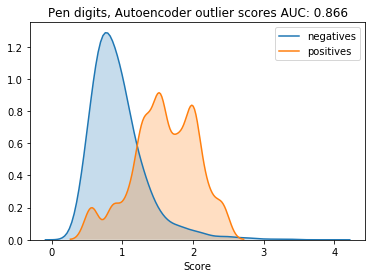

In [415]:
y_train_scores = clf.decision_scores_  # raw outlier scores
res = plot_outlier_scores(y_pen.values, y_train_scores, bw=0.1, title='Pen digits, Autoencoder outlier scores')

**Extra: check the reconstruction error visually**

In [418]:
positive_idx = list(y_pen[y_pen==1].index)[:3]
negative_idx = list(y_pen[y_pen==0].index)[:3]

In [419]:
# Compare the original with the reconstruction to get a feeling (in StandardScaled space)
def show_reconstruction(clf, data, index, ax, title=''):
    if isinstance(data, pd.DataFrame):
        data = data.values
    data_recon = clf.model_.predict(data[[index], :])
    ax.plot(data[index, :], label='original')
    ax.plot(data_recon[0, :], label='reconstructed', linestyle='--');
    ax.legend()
    ax.set_title(title);

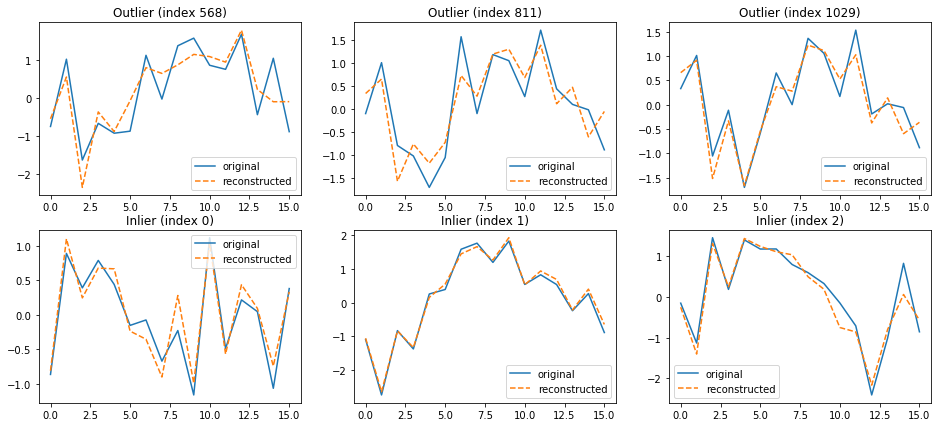

In [420]:
fig, axs = plt.subplots(2, 3, figsize=(16, 7))
titles = ['Outlier', 'Inlier']
for i, idxs in enumerate([positive_idx, negative_idx]):
    for j, idx in enumerate(idxs):
        show_reconstruction(clf, x_pen, index=idx, ax=axs[i, j], title=titles[i]  + f' (index {idx})'
                            )

### Extra:  DBSCAN

In [81]:
def make_dbscan_outlierscore(labels):
    """ Returns outlier scores from db scan labels
    The -1 cluster are defined as outliers, and get the highest outlier score
    Other clusters: the smaller the cluster, the larger the outlier score
    
    labels (np.ndarray) : cluster labels
    
    Returns: outlier_scores (np.ndarray)
    """
    cluster_counter = Counter(labels)
    del cluster_counter[-1] # Outliers will get score 1 at the end
    cluster_label, cluster_size = (np.array(list(cluster_counter.keys())), 
                                   np.array(list(cluster_counter.values())))
    
    cluster_order = cluster_label[np.argsort(cluster_size)][::-1]
    scores = np.array(range(len(cluster_label))) / len(cluster_label)
    cluster_mapping = {c:s for c, s in zip(cluster_order, scores)}
    cluster_mapping = {**cluster_mapping, -1:1}
    outlier_scores = np.vectorize(cluster_mapping.get)(labels)
    return outlier_scores
    
    

DBSCAN has two parameters to choose. min_samples has a smaller influence than epsilon. Larger epsilon results in fewer clusters. A somewhat smaller epsilon (resulting in ~10 clusters) seems beneficial. 

In [82]:
db = DBSCAN(eps=1.5, min_samples=10)
db.fit(x_pen_scaled)

DBSCAN(algorithm='auto', eps=1.5, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=10, n_jobs=None, p=None)

In [83]:
db_outlier_scores = make_dbscan_outlierscore(db.labels_)

In [34]:
len(np.unique(db.labels_))

11

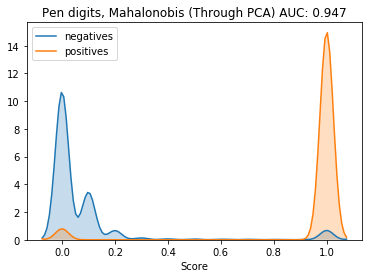

In [35]:
res = plot_outlier_scores(y_pen.values, db_outlier_scores, bw=0.025, title='Pen digits, Mahalonobis (Through PCA)')

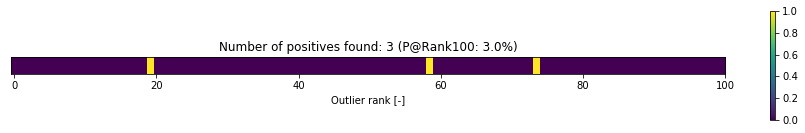

In [36]:
res = plot_top_N(y_pen.values, db_outlier_scores, N=100)

In [37]:
roc_scores_dbscan = {eps: roc_auc_score(y_pen.values, 
                                        make_dbscan_outlierscore(DBSCAN(eps=eps, min_samples=10)
                                                                 .fit(x_pen_scaled)
                                                                 .labels_)) 
                     for eps in  [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]}

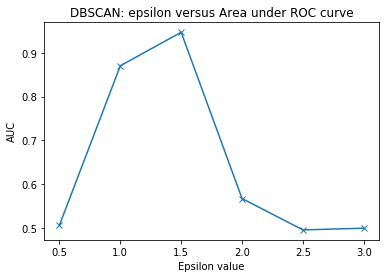

In [38]:
plt.plot(list(roc_scores_dbscan.keys()), list(roc_scores_dbscan.values()), '-x');
plt.xlabel('Epsilon value')
plt.ylabel('AUC')
plt.title('DBSCAN: epsilon versus Area under ROC curve');